# 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.auto import tqdm

# for smp, we manually install *segmentation_models_pytorch* and summery
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = "cuda" if torch.cuda.is_available() else "cpu"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.4 MB/s eta 0:00:00


In [3]:
!pip install kaggle

In [4]:
# download API token from Kaggle and sekect here
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
# Move the uploaded kaggle.json file to the required directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


mv: cannot stat 'kaggle.json': No such file or directory


In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
## now download dataset
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset

 99% 3.87G/3.89G [00:41<00:00, 79.5MB/s]
100% 3.89G/3.89G [00:41<00:00, 100MB/s] 


In [9]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "Aerial drone dataset"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    ## code from my previous projects
    # Download pizza, steak, sushi data
    # with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    #     request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    #     print("Downloading pizza, steak, sushi data...")
    #     f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile('/content/semantic-drone-dataset.zip', "r") as zip_ref:
        print("Unzipping Images ...")
        zip_ref.extractall(image_path)

Did not find data/Aerial drone dataset directory, creating one...
Unzipping Images ...


# 2. Preprocessing

In [10]:
IMAGE_PATH = '/content/data/Aerial drone dataset/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '/content/data/Aerial drone dataset/dataset/semantic_drone_dataset/label_images_semantic/'

In [11]:
n_classes = 23

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [12]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print(f"Train Size: {len(X_train)}")
print(f"Test Size: {len(X_test)}")
print(f"Validation Size: {len(X_val)}")


Train Size: 306
Test Size: 40
Validation Size: 54


Image size (4000, 6000, 3)
Mask Size (4000, 6000)


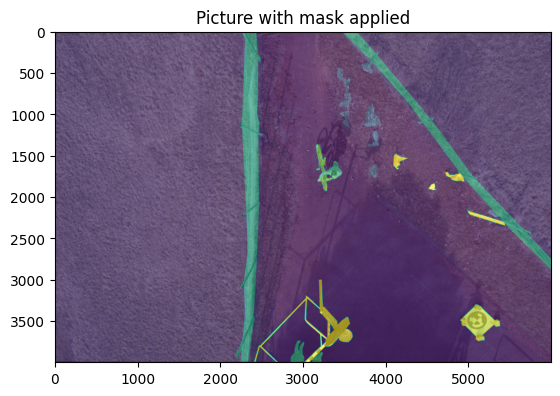

In [13]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title("Picture with mask applied")
plt.show();


# 3.Dataset

In [14]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DroneDataset(Dataset):
  def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
    self.img_path = img_path
    self.mask_path = mask_path
    self.X = X
    self.transform = transform
    self.patches = patch
    self.mean = mean
    self.std = std

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

    if self.transform is not None:
      aug = self.transform(image=img, mask=mask)
      img = Image.fromarray(aug['image'])
      mask = aug['mask']
    if self.transform is None:
      img = Image.fromarray(img)

    t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
    img = t(img)
    mask = torch.from_numpy(mask).long()

    if self.patches:
      img, mask = self.tiles(img, mask)

    return img, mask

  def tiles(self, img, mask):


    img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
    img_patches = img_patches.contiguous().view(3, -1, 512, 786)
    img_patches = img_patches.permute(1, 0, 2, 3)

    mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
    mask_patches = mask_patches.contiguous().view(-1, 512, 768)

    return img_patches, mask_patches

In [15]:
mean = [0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0, 0.5), (0, 0.5)),
                     A.GaussNoise(),])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)
                   ])
# datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

# DataLoader
batch_size = 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)


# 3. Model

In [16]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 184MB/s]


In [17]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

# 4. Training

In [18]:
def pixel_accuracy(output, mask):
  with torch.no_grad():
    output = torch.argmax(F.softmax(output, dim=1), dim=1)
    correct = torch.eq(output, mask).int()
    accuracy = float(correct.sum()) / float(correct.numel())
  return accuracy

In [19]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
  with torch.no_grad():
    pred_mask = F.softmax(pred_mask, dim=1)
    pred_mask = torch.argmax(pred_mask, dim=1)
    pred_mask = pred_mask.contiguous().view(-1)
    mask = mask.contiguous().view(-1)

    iou_per_class = []
    for clas in range(0, n_classes): # loop per pixel class
      true_class = pred_mask == clas
      true_label = mask == clas

      if true_label.long().sum().item() == 0:
         # no exist label in this loop
         iou_per_class.append(np.nan)
      else:
        intersect = torch.logical_and(true_class, true_label).sum().float().item()
        union = torch.logical_or(true_class, true_label).sum().float().item()

        iou = (intersect + smooth) / (union+smooth)
        iou_per_class.append(iou)
    return np.nanmean(iou_per_class)





In [20]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history


In [21]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.611 
Epoch:1/15.. Train Loss: 2.581.. Val Loss: 1.611.. Train mIoU:0.061.. Val mIoU: 0.108.. Train Acc:0.342.. Val Acc:0.640.. Time: 4.78m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.611 >> 1.249 
Epoch:2/15.. Train Loss: 1.744.. Val Loss: 1.249.. Train mIoU:0.109.. Val mIoU: 0.127.. Train Acc:0.593.. Val Acc:0.676.. Time: 4.72m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/15.. Train Loss: 1.499.. Val Loss: 1.520.. Train mIoU:0.121.. Val mIoU: 0.118.. Train Acc:0.599.. Val Acc:0.594.. Time: 4.59m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.520 >> 1.141 
Epoch:4/15.. Train Loss: 1.357.. Val Loss: 1.141.. Train mIoU:0.139.. Val mIoU: 0.142.. Train Acc:0.615.. Val Acc:0.656.. Time: 4.63m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.141 >> 1.039 
saving model...
Epoch:5/15.. Train Loss: 1.265.. Val Loss: 1.039.. Train mIoU:0.146.. Val mIoU: 0.171.. Train Acc:0.637.. Val Acc:0.713.. Time: 4.68m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.039 >> 0.877 
Epoch:6/15.. Train Loss: 1.155.. Val Loss: 0.877.. Train mIoU:0.164.. Val mIoU: 0.207.. Train Acc:0.661.. Val Acc:0.753.. Time: 4.71m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:7/15.. Train Loss: 1.082.. Val Loss: 0.891.. Train mIoU:0.186.. Val mIoU: 0.222.. Train Acc:0.683.. Val Acc:0.746.. Time: 4.74m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.891 >> 0.802 
Epoch:8/15.. Train Loss: 1.030.. Val Loss: 0.802.. Train mIoU:0.205.. Val mIoU: 0.231.. Train Acc:0.700.. Val Acc:0.763.. Time: 4.75m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.802 >> 0.749 
Epoch:9/15.. Train Loss: 0.916.. Val Loss: 0.749.. Train mIoU:0.224.. Val mIoU: 0.240.. Train Acc:0.732.. Val Acc:0.777.. Time: 4.72m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.749 >> 0.651 
Epoch:10/15.. Train Loss: 0.867.. Val Loss: 0.651.. Train mIoU:0.238.. Val mIoU: 0.256.. Train Acc:0.750.. Val Acc:0.801.. Time: 4.71m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:11/15.. Train Loss: 0.812.. Val Loss: 0.675.. Train mIoU:0.250.. Val mIoU: 0.260.. Train Acc:0.762.. Val Acc:0.792.. Time: 4.66m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.675 >> 0.604 
saving model...
Epoch:12/15.. Train Loss: 0.736.. Val Loss: 0.604.. Train mIoU:0.270.. Val mIoU: 0.277.. Train Acc:0.784.. Val Acc:0.812.. Time: 4.64m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.604 >> 0.586 
Epoch:13/15.. Train Loss: 0.698.. Val Loss: 0.586.. Train mIoU:0.281.. Val mIoU: 0.295.. Train Acc:0.794.. Val Acc:0.820.. Time: 4.57m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.586 >> 0.578 
Epoch:14/15.. Train Loss: 0.681.. Val Loss: 0.578.. Train mIoU:0.286.. Val mIoU: 0.295.. Train Acc:0.800.. Val Acc:0.822.. Time: 4.64m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:15/15.. Train Loss: 0.656.. Val Loss: 0.583.. Train mIoU:0.295.. Val mIoU: 0.302.. Train Acc:0.808.. Val Acc:0.823.. Time: 4.63m
Total time: 70.17 m


In [22]:
torch.save(model, "Unet-Mobilenet.pt")

In [23]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

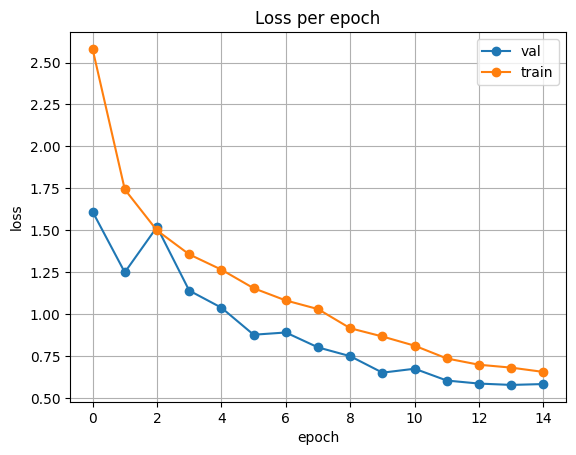

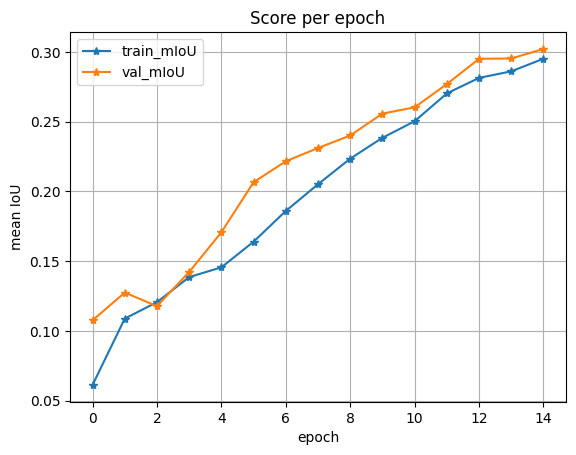

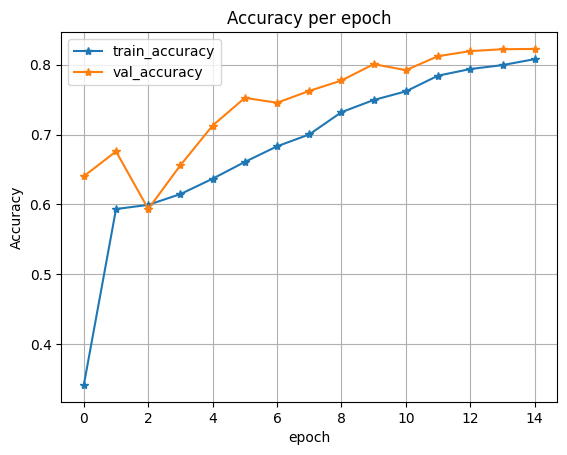

In [24]:
plot_loss(history)
plot_score(history)
plot_acc(history)

## Evaluation

In [27]:
class DroneTestDataset(Dataset):
  def __init__(self, img_path, mask_path, X, transform=None):
    self.img_path = img_path
    self.mask_path = mask_path
    self.X = X
    self.transform = transform

  def __len__(self):
    return len(self.X)
  def __getitem__(self, idx):
    img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

    if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

    if self.transform is None:
            img = Image.fromarray(img)

    mask = torch.from_numpy(mask).long()

    return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

##Result

In [28]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [29]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [30]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [31]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [32]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [33]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [34]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

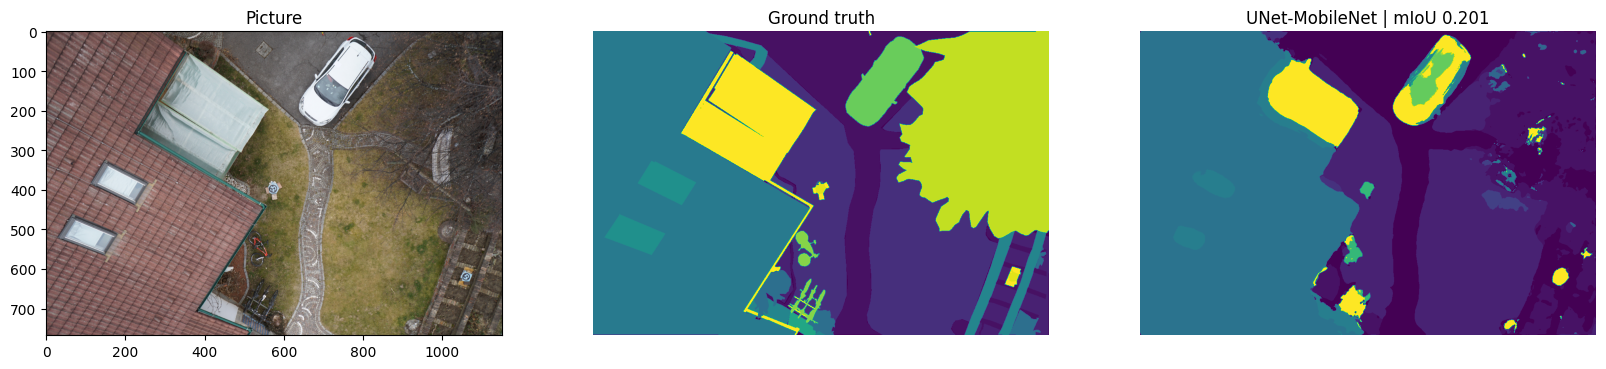

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

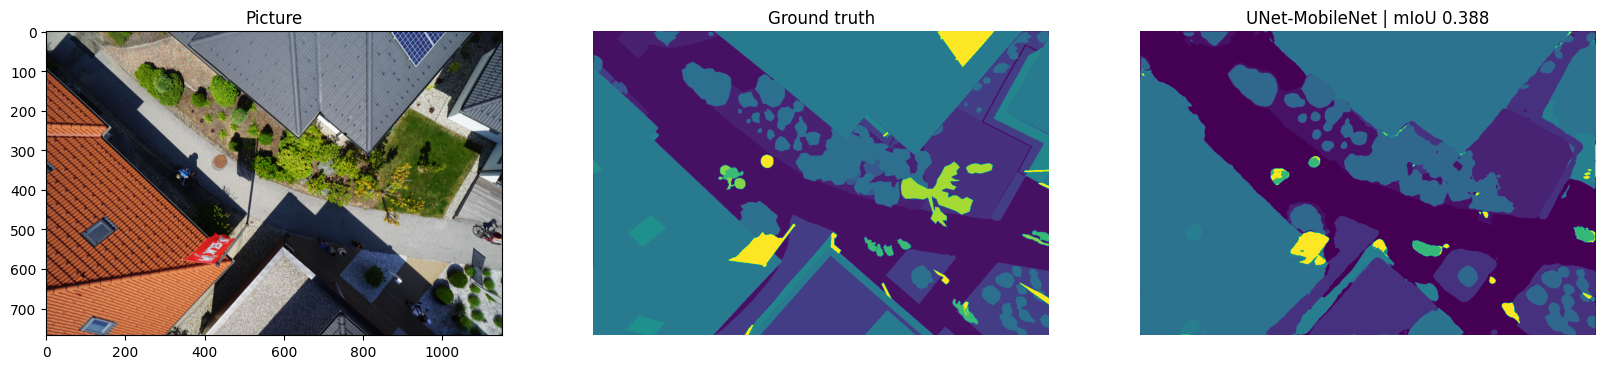

In [36]:

image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

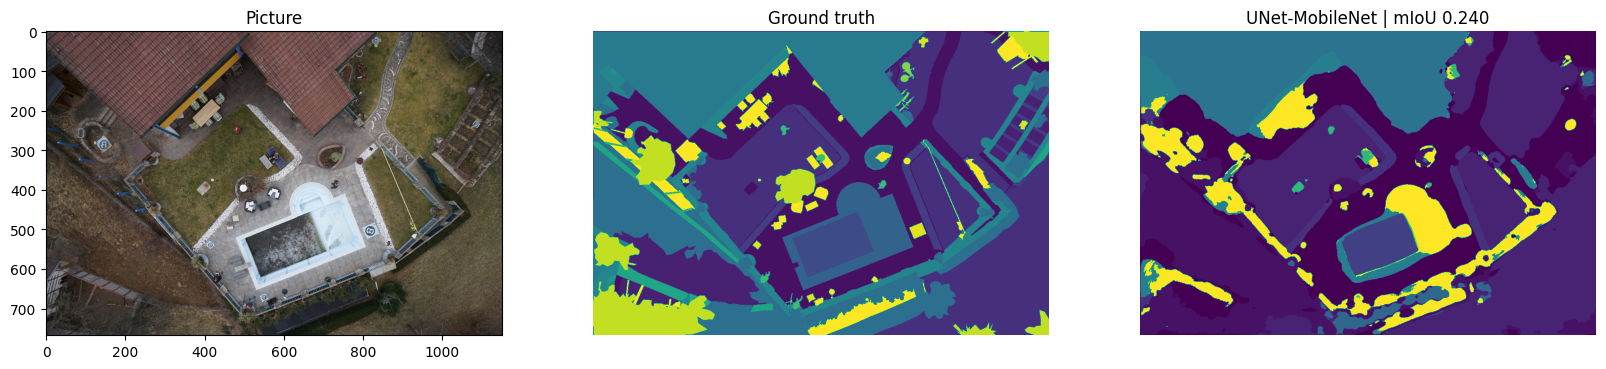

In [37]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [38]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.3323687168220961


In [39]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.8127169008608218
